# GDELT: Research In The South Pacific

Written by Derek Lilienthal (California State University Monterey Bay) <br> 
Mentored by Dr. Elizabeth Gooch (Naval Postgraduate School)

<h1> Introduction </h1>

The GDELT (Global Database of Events, Language and Tone) Project's objective is to collect information from every news source in the world and have it all in one place. GDELT give us a big data resource to analyze the world's news and allows researchers to explore trends in media that was not easily accessible before. GDELT stores all of its data in a relational database that is freely accessible through Googles BigQuery. This allows researchers to use SQL to access and aggregate the data. 

The amount of raw data that GDELT gives researchers is monumental. In one of the relational database tables, that we focus on in this research, there are over 5 billion different observations. The GDELT Project database itself has over 50 tables, but for the purpose of this research, we will solely be focusing on three of GDELT's tables. The Events, Eventmentions, and GKG (Global Knowledge Graph). GDELT also updates the Events and Eventmentions table every 15 minutes. This makes it possible to track events as they are happening in almost real time. 

The Events table is where GDELT creates a new entry for each brand new event, the Eventmentions table is where GDELT tracks the life of each event as it spans across more media outlets and as the event continues to develop, and the GKG table is a detailed analysis of every news article itself. 

An example on how these three tables relate to each other, if Fox News is the first to report on about a political scandal, the event will first have an entry in the Events table. After 15 minutes, any follow-up news articles, or a new media outlets like CNN, that report on the same event will all be separate entries in the Eventmentions table. Each event is uniquely identified by a unique id (GLOBALEVENTID) in the Events table that is also present in each entry in the Eventmentions table. This way, we are able to join both the Event and Eventmentions table on each events unique id. We can also track individual events by there GLOBALEVENTID. The GKG table however uniquely identifies each event by the articles URL. This way, we are able to join the Eventmentions and GKG tables through each events URL because the Eventmentions table also has the URL of where the article came from. This research will focus on all the entries collected by combining all three tables together.

Each event in the Events table is stored in a CAMEO (Conflict And Mediation Event Observation) format where the two actors and the action performed by Actor1 upon Actor2 is recorded. The Geographical location where the event took place is also recorded along with the geographical location where Actor1 and Actor2 reside from. If the event only involves one or no actors, then these attributes can be left blank. 

The Eventmentions table is an extension of the Events table. It records all the mentions of each event as it spans across multiple news sources. It will track an event as it spans past the first initial recording in the Events table. The Eventmentions table also includes more additional details about each one of the entries in the table like the articles tone, actors character offset in the article, confidence level of the reported article is related to the GLOBALEVENTID, and many more attributes. For this research, we will solely be focusing on the tone reported by the Eventmentions table.

The GKG table 'connects every person, organization, location, count, theme, news source, and event across the planet into a single massive network that captures whats happening around the world, what its connect is and who's involved, and how the world is feeling about it, every single day' (GKG Codebook). In short terms, the GKG table gives an additional level of analysis on each event recorded in GDELT that can be used to filter articles by organizations, persons, themes, tones, locations, and more. For this research, we will primarily be focusing on using the themes and tones of the GKG table. 

In this research, we will be focusing on analyzing western, Chinese and local media tones across the South Pacific when a great power is either Actor1 or Actor2, the location of the event is a South Pacific country or territory, and the event involves the environment. The great powers of interest in this research are: The United States, China, Australia, New Zealand, Japan, and Russia. The locations of interest in the South Pacific are: Micronesia, Fiji, Kiribati, Marshall Islands, Nauru, Palau, Papua New Guinea, Samoa, Solomon Islands, Tonga, Tuvalu, Vanuatu, Cook Islands, Niue, American Samoa, Ashmore Reef, Baker Island, Coral Sea, Easter Island, Galapagos Islands, French Polynesia, Guam, Howland Island, Jarvis Island, Johnston Atoll, Kingman Reef, Midway Island, New Caledonia, Norfold Island, Norther Mariana Islands, Ogasawaramura Japan, Palmyra Atoll, Papua Indonesia, Pitcairn Islands, Tokelau, Wake Island, Wallis and Futuna, West Papua, and Bonin Islands. 

<em>Note, we did not include every location in the South Pacific (Hawaii, New Zealand and Australia) because those three locations accounted for the majority of all the entries in our South Pacific subset of data from GDELT.</em>

In [1]:
# Load in all the imports and set default settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.ticker as ticker
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set(color_codes=True)
sns.set(font_scale=2)
color1 = '#003f5c'
color2 = '#bc5090'
color3 = '#ffa600'

<em> To hide all the code in this report in Jupyter Notebooks, press the button below </em>

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

<h1> Data </h1>

<h3> Articles in the South Pacific </h3>

The first thing i looked at is what percentage of articles/events take place in the south pacific? To answer this question, there is a few things we need to know. The first one is how many events are in GDELT itself and the second is dividing that amount of how many articles are located in the South Pacific. 

To get the total number of articles within GDELT itself, i constructed a query to count all the articles when joining the three tables of interest. Events, Eventmentions, and GKG. <br> 

    SELECT 
        count(1) 
    FROM 
      `gdelt-bq.gdeltv2.eventmentions_partitioned` AS eventmentions JOIN `gdelt-bq.gdeltv2.events_partitioned` AS events ON eventmentions.GLOBALEVENTID = events.GLOBALEVENTID INNER JOIN `gdelt-bq.gdeltv2.gkg_partitioned`AS GKG ON eventmentions.MentionIdentifier = GKG.DocumentIdentifier

This query was pulled on 11/03/2020 @ 11:25 PM PST <br>
It produced a result of: <b> 5563232445 </b> <br>
This means there are 5,563,232,445 articles contained in all of GDELT as of that instance in time

Next, to get the total number of articles that take place in the South Pacific, i constructed a query to count all the articles in GDELT using predicates to specify the locations in the South Pacific.

    SELECT 
        count(1)
    FROM 
      `gdelt-bq.gdeltv2.eventmentions_partitioned` as eventmentions join `gdelt-bq.gdeltv2.events_partitioned` as events 
    ON eventmentions.GLOBALEVENTID = events.GLOBALEVENTID inner join `gdelt-bq.gdeltv2.gkg_partitioned`as GKG on eventmentions.MentionIdentifier = GKG.DocumentIdentifier
    WHERE 
      (ActionGeo_ADM1Code like 'FM%' -- Micronesia
      OR ActionGeo_ADM1Code like 'FJ%' -- Fiji
      OR ActionGeo_ADM1Code like 'KR%' -- Kiribati
      OR ActionGeo_ADM1Code like 'RM%' -- Marshall Islands
      OR ActionGeo_ADM1Code like 'NR%' -- Nauru
      OR ActionGeo_ADM1Code like 'PS%' -- Palau
      OR ActionGeo_ADM1Code like 'PP%' -- Papua New Guinea
      OR ActionGeo_ADM1Code like 'WS%' -- Samoa
      OR ActionGeo_ADM1Code like 'BP%' -- Solomon Islands
      OR ActionGeo_ADM1Code like 'TN%' -- Tonga
      OR ActionGeo_ADM1Code like 'TV%' -- Tuvalu
      OR ActionGeo_ADM1Code like 'NH%' -- Vanuatu
      OR ActionGeo_ADM1Code like 'CW%' -- Cook Islands
      OR ActionGeo_ADM1Code like 'NE%' -- Niue
      OR ActionGeo_ADM1Code like 'AQ%' -- American Samoa
      OR ActionGeo_FullName = 'Ashmore Reef, Queensland, Australia'
      OR ActionGeo_ADM1Code like 'FQ%' -- Baker Island
      OR ActionGeo_FullName = 'Coral Sea, Oceans (general), Oceans'
      OR ActionGeo_FullName like 'Easter Island, V%'
      OR ActionGeo_FullName = 'Galapagos, Imbabura, Ecuador'
      OR ActionGeo_ADM1Code like 'FP%' -- French Polynesia
      OR ActionGeo_ADM1Code like 'GQ%' -- Guam
      OR ActionGeo_ADM1Code like 'HQ%' -- Howland Island
      OR ActionGeo_ADM1Code like 'DQ%' -- Jarvis Island
      OR ActionGeo_ADM1Code like 'JQ%' -- Johnston Atoll
      OR ActionGeo_ADM1Code like 'KQ%' -- Kingman Reef
      OR ActionGeo_FullName = 'Midway Island, Western Australia, Australia'
      OR ActionGeo_ADM1Code like 'NC%' -- New Caledonia
      OR ActionGeo_ADM1Code like 'NF%' -- Norfold Island
      OR ActionGeo_ADM1Code like 'CQ%' -- Norther Mariana Islands
      OR ActionGeo_FullName = 'Ogasawaramura, Tokyo, Japan'
      OR ActionGeo_ADM1Code like 'LQ%' -- Palmyra Atoll
      OR ActionGeo_ADM1Code = 'ID36' -- Papua, Indonesia
      OR ActionGeo_ADM1Code like 'PC%' -- Pitcairn Islands
      OR ActionGeo_ADM1Code like 'TL%' -- Tokelau
      OR ActionGeo_ADM1Code like 'WQ%' -- Wake Island
      OR ActionGeo_ADM1Code like 'WF%' -- Wallis and Futuna
      OR ActionGeo_ADM1Code = 'ID39' -- West Papua, Indonesia
      OR ActionGeo_FullName = 'Bonin Islands, Tokyo, Japan')

This query was pulled on 11/03/2020 @ 11:23 PM PST <br>
It produced a result of: <b> 4315294 </b> <br>
This means there are 4,315,294 articles contained in all of GDELT as of that instance in time

<em> Below is a visualization of the percentage of articles within GDELT that are located in the South Pacific </em>

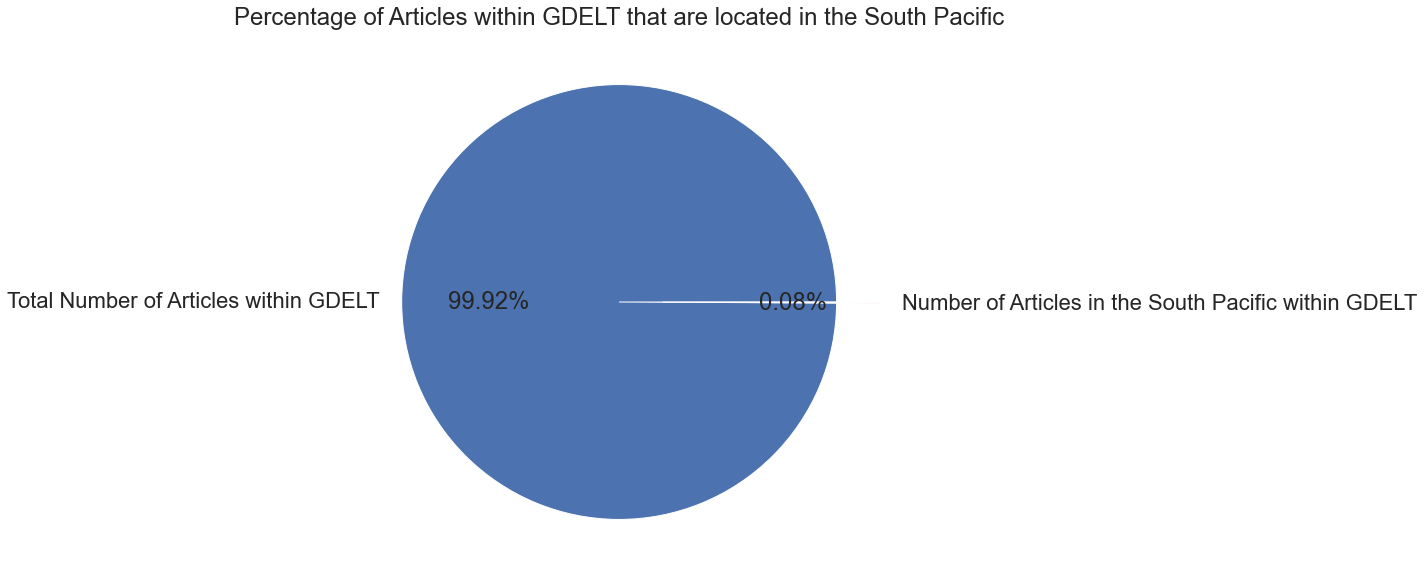

In [159]:
labels = 'Total Number of Articles within GDELT', 'Number of Articles in the South Pacific within GDELT'
sizes = [5563232445, (5563232445 - (5563232445 - 4315294))]
explode = (0,0.2)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%')
plt.title("Percentage of Articles within GDELT that are located in the South Pacific");

Out of all the articles contained within GDELT, only 0.08% of them are in the South Pacific.

<h3> Articles in the South Pacific involving an Environmental Issue </h3>

Next, to further specify what i am researching, i will be examining how many articles in the South Pacific are written that involve some environmental issue. 

<em> Refer to the file 'Creating_Datasets' for exact source code on how i created my data sets used in this report </em>

In [160]:
# Load in the mini data set only containing ENV_ themes 
#data_file = 'D:/UROC_CSV/Final Pull/Final_Pull_Mini_ENV.csv'
#df = pd.read_csv(data_file)

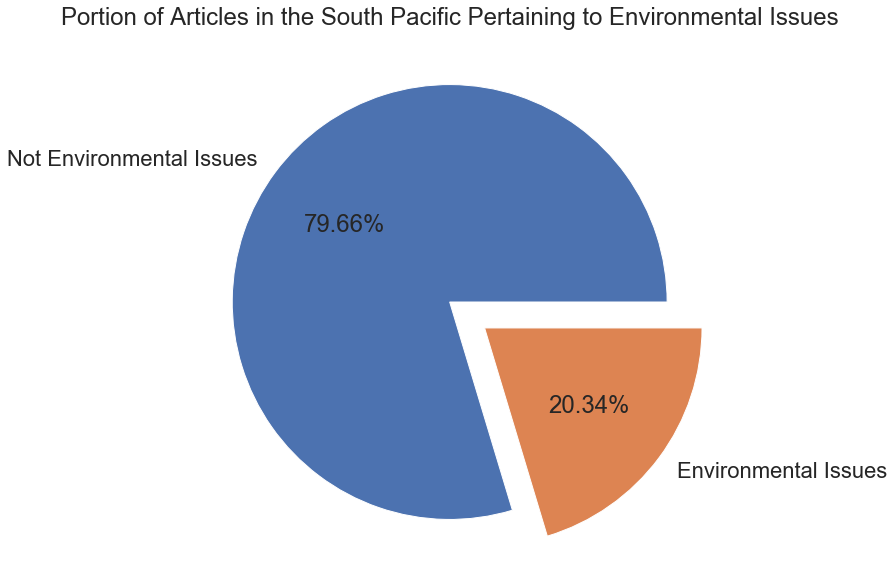

In [2]:
labels = ['Not Environmental Issues', 'Environmental Issues']
sizes = [(4315294 - 877841), 877841] # 877841 comes from Creating_Datasets
explode = (0,0.2)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%')
plt.title("Portion of Articles in the South Pacific Pertaining to Environmental Issues");

Of all the articles in GDELT in the South Pacific, 20.34% involve an environmental issue and 79.66% do not.

<h3> Percentage of Articles With an Environment Theme in the South Pacific Involving a Great Power </h3>

Next, i will be looking at the percentage of environmental events in the South Pacific involve a great power. 

In order to find the percentages, there will be two numbers i need to know: <br>
1. How many environmental articles are located in the South Pacific.
2. How many of those articles involve a great power

In [2]:
# Load in the dataset that is filtered by having Actor1/2CountryCode being a Great Power and involving an ENV_ theme
data_file = 'D:/UROC_CSV/Final Pull/Final_Pull_Mini_GP1_ENV.csv'
df = pd.read_csv(data_file)

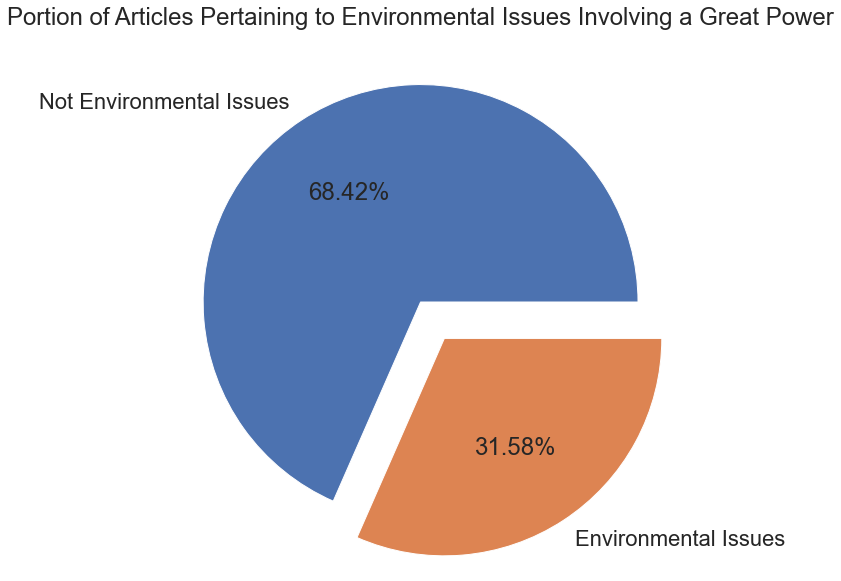

In [3]:
labels = ['Not Environmental Issues', 'Environmental Issues']
# sizes = [(877841 - df.shape[0]), df.shape[0]] 
sizes = [(877841 - 277215), 277215] # The number 277215 comes from the Creating_Datasets file
explode = (0,0.2)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%')
plt.title("Portion of Articles Pertaining to Environmental Issues Involving a Great Power");

Of all the articles in GDELT located in the South Pacific and that involve one of the great powers as Actor1CountryCode or Actor2CountryCode, 31.58% involve an environmental issue and 68.42% do not.

Next, i show the breakdown of each of the great powers.

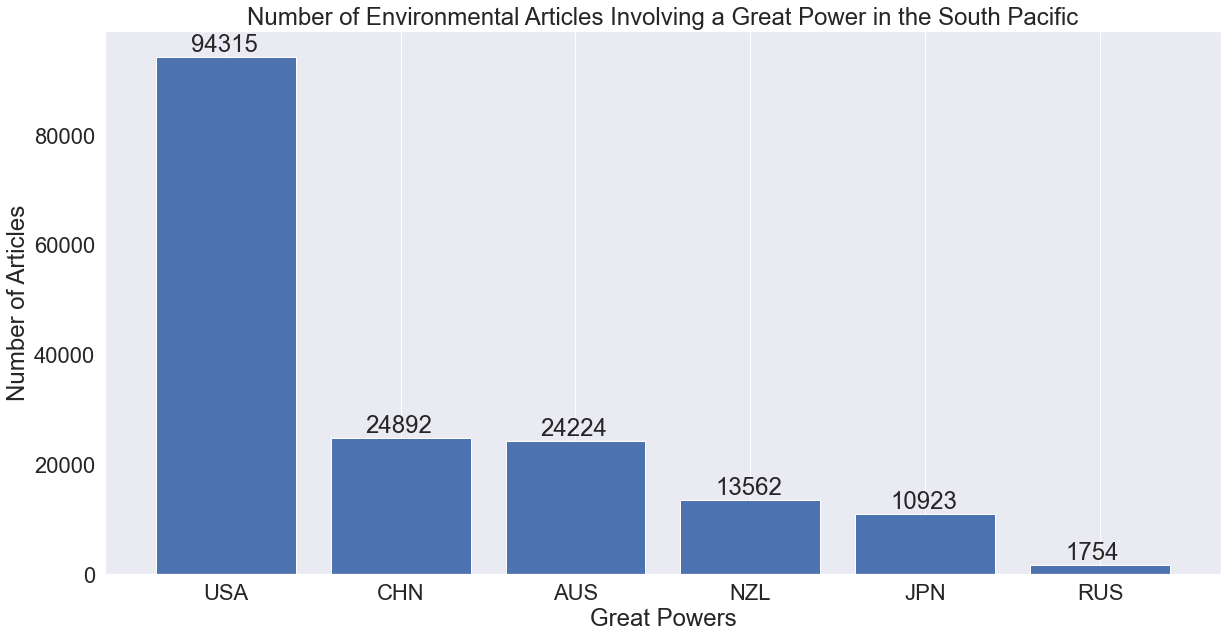

In [4]:
great_powers = ['USA','JPN','CHN','NZL','AUS','RUS']
temp_dic = {}

# This function counts all the intances of a great power as Actor1/2CountryCode and stores the results into a dictionary
def countGP(gp):
    mask = (df['Actor1CountryCode'] == gp) | (df['Actor2CountryCode'] == gp)
    temp_dic[gp] = int(df['Actor1CountryCode'][mask].value_counts()[:1].values)

# Itterate through all the great powers in dataset
for gp in great_powers:
    countGP(gp)

# Sort the dictionary results
result_dict = {k: v for k, v in sorted(temp_dic.items(), key=lambda item: item[1], reverse=True)}
# Plot
ax = plt.bar(result_dict.keys(), result_dict.values())
plt.title("Number of Environmental Articles Involving a Great Power in the South Pacific")
plt.xlabel("Great Powers")
plt.ylabel("Number of Articles")
plt.grid(axis='y')

# Add the labels
for i, col in enumerate(ax.patches):
    plt.text(col.get_x()+.2, col.get_height() + 1000, list(result_dict.values())[i])

Next is the percentage breakdown.

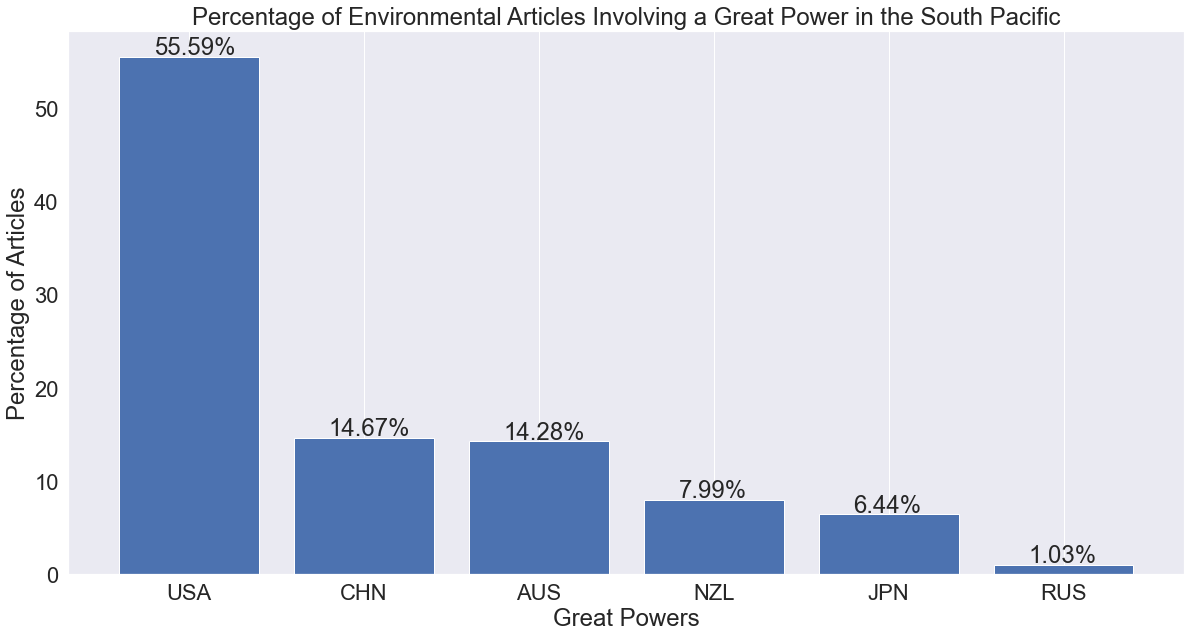

In [5]:
# This function takes in a dictionary and normalizes all the values
def normalize(d):
   raw = sum(d.values())
   factor = 100.0/raw
   return {key:value*factor for key,value in d.items()}

result_dict = normalize(result_dict)
result_dict = {k: v for k, v in sorted(result_dict.items(), key=lambda item: item[1], reverse=True)}

# Plot
ax = plt.bar(result_dict.keys(), result_dict.values())
plt.title("Percentage of Environmental Articles Involving a Great Power in the South Pacific")
plt.xlabel("Great Powers")
plt.ylabel("Percentage of Articles")
plt.grid(axis='y')
plt.tick_params(axis='y')

# Add the percentage labels
for i, col in enumerate(ax.patches):
    plt.text(col.get_x()+.2, col.get_height() + 0.2, str(round(list(result_dict.values())[i],2))+"%")

<h3> Percent of enviromental South Pacific articles involving a great power that were reported on by local sources </h3>

In [6]:
local_sources = ['samoanews.com', 'samoaobserver.ws', 'solomonstarnews.com',
                 'solomontimes.com', 'islandsun.com.sb', 'saipantribune.com',
                 'fijisun.com.fj', 'fijitimes.com', 'fijivillage.com',
                 'fiji.gov.fj', 'fijione.tv', 'thejetnewspaper.com',
                 'islandsbusiness.com', 'kpress.info', 'presidence.pf',
                 'ladepeche.pf', 'guampdn.com', 'kuam.com',
                 'pacificnewscenter.com', 'mvguam.com', 'postguam.com',
                 'pncguam.com', 'dailypost.vu', 'nouvellecaledonie.la1ere.fr',
                 'postcourier.com.pg', 'emtv.com.pg', 'thenational.com.pg',
                 'marshallislandsjournal.com', 'tonga-broadcasting.net', 'matangitonga.to',
                 'tongadailynews.to', 'parliament.gov.to', 'mic.gov.to',
                 'planet-tonga.com']

western_sources = ["yahoo.com", "bbc.co.uk", "foxnews.com", 
                   "nbcnews.com", "go.com", "cbsnews.com", 
                   "nytimes.com", "msn.com", "usatoday.com", 
                   "npr.org"]

chinese_sources = ["xinhuanet.com", "chinadaily.com.cn", "china.org.cn", 
                   "ecns.cn", "peopledaily.com.cn"]

There are <b>277,215</b> articles in the Environmental South Pacific that involve a Great Power. <br>

In order to count how many of those articles have been reported on by local sources, i will need to tabulate all the instances where a local source is the source name.

In [7]:
count = 0
for row in df['MentionSourceName'].astype(str):
    for source in local_sources:
        if source in row:
            count += 1
print("There are {} articles in the South Pacific write by local new sources".format(count))

There are 19423 articles in the South Pacific write by local new sources


In [8]:
portion = (19423 / 277215) * 100
print("There portion of articles in the South Pacific in GDELT writen by local sources involving an ENV_ theme and a great power is {:.2f}%".format(portion))

There portion of articles in the South Pacific in GDELT writen by local sources involving an ENV_ theme and a great power is 7.01%


Only 7.01% of the articles involving a great power and an environment theme in the South Pacific are reported on by the local news sources of South Pacific. The other 92.99% of articles are reported on news sources that are not based in the South Pacific. 

<h3> Comparing Western, Chinese, and Local Media Tones </h3>

Next, i will be examining the tones of the Western, Chinese, and Local new sources.

In [9]:
"""
In order to do calculations on the next few tones, i will need to split the GKG Tone 
into separate components in order to efficiently calculate the GKG tone
"""

def split_tone1(df):
    temp = df.split(",")
    return temp[0]
df['V2Tone_New'] = df['V2Tone'].apply(split_tone1)

def split_tone2(df):
    temp = df.split(",")
    return temp[1]
df['Positive_Tone'] = df['V2Tone'].apply(split_tone2)

def split_tone3(df):
    temp = df.split(",")
    return temp[2]
df['Negative_Tone'] = df['V2Tone'].apply(split_tone3)

def split_tone4(df):
    temp = df.split(",")
    return temp[3]
df['Polarity'] = df['V2Tone'].apply(split_tone4)

def split_tone5(df):
    temp = df.split(",")
    return temp[4]
df['Activity_Reference_Density'] = df['V2Tone'].apply(split_tone5)

def split_tone6(df):
    temp = df.split(",")
    return temp[5]
df['SelfGroup_Reference_Density'] = df['V2Tone'].apply(split_tone6)

def split_tone7(df):
    temp = df.split(",")
    return temp[6]
df['Word_Count'] = df['V2Tone'].apply(split_tone7)

In [10]:
# Convert the columns into float data-types
df['V2Tone_New'] = df['V2Tone_New'].astype(float)
df['AvgTone'] = df['AvgTone'].astype(float)
df['MentionDocTone'] = df['MentionDocTone'].astype(float)

In [11]:
# Create lists to store the average tones to compare later
avg_chinese_tones = []
avg_western_tones = []
avg_local_tones = []

<b> Western Sources Tone </b>

First, i will look at the tones of western news sources. 

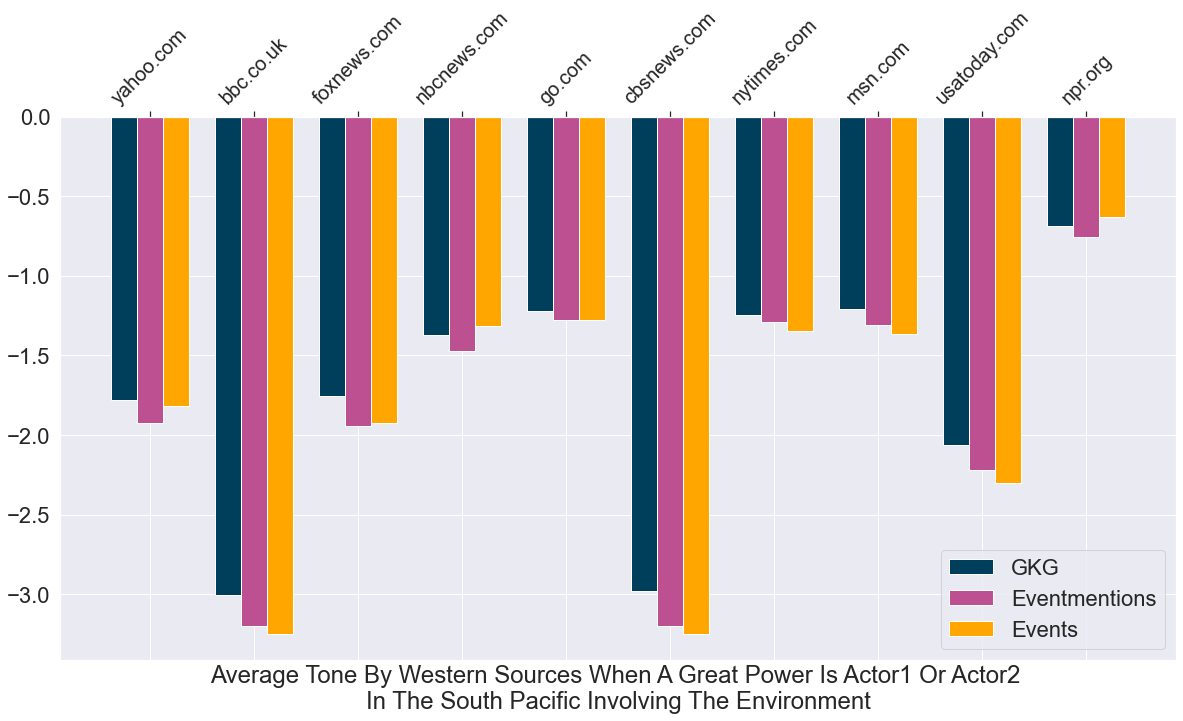

In [13]:
# Store the results to compute a weighted average
result_gkg = []
result_em = []
result_e = []
num_articles = []

# Loop through each one of the western sources and take the average of each one
for w_source in western_sources:
    avg_tone_gkg = df[df['SourceCommonName'] == w_source]['V2Tone_New'].mean()
    avg_tone_e = df[df['SourceCommonName'] == w_source]['AvgTone'].mean()
    avg_tone_em = df[df['SourceCommonName'] == w_source]['MentionDocTone'].mean()
    num_art = df[df['SourceCommonName'] == w_source].shape[0]
    num_articles.append(num_art)
    result_gkg.append(avg_tone_gkg)
    result_em.append(avg_tone_em)
    result_e.append(avg_tone_e)
    
# Code for graph    
labels = ["GKG","Eventmentions","Events"]
fig, ax = plt.subplots()

x = np.arange(len(western_sources))
width = 0.25

r1 = np.arange(len(western_sources))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, result_gkg, color=color1, width=width, label='GKG')
ax.bar(r2, result_em, color=color2, width=width, label='Eventmentions')
ax.bar(r3, result_e, color=color3, width=width, label='Events')
ax.set_xlabel('Average Tone By Western Sources When A Great Power Is Actor1 Or Actor2 \nIn The South Pacific Involving The Environment')
plt.xticks([r + width for r in range(len(western_sources))], western_sources)
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', labelsize=20, rotation=45)
ax.legend();

Next, is the weighted average of all three tones.

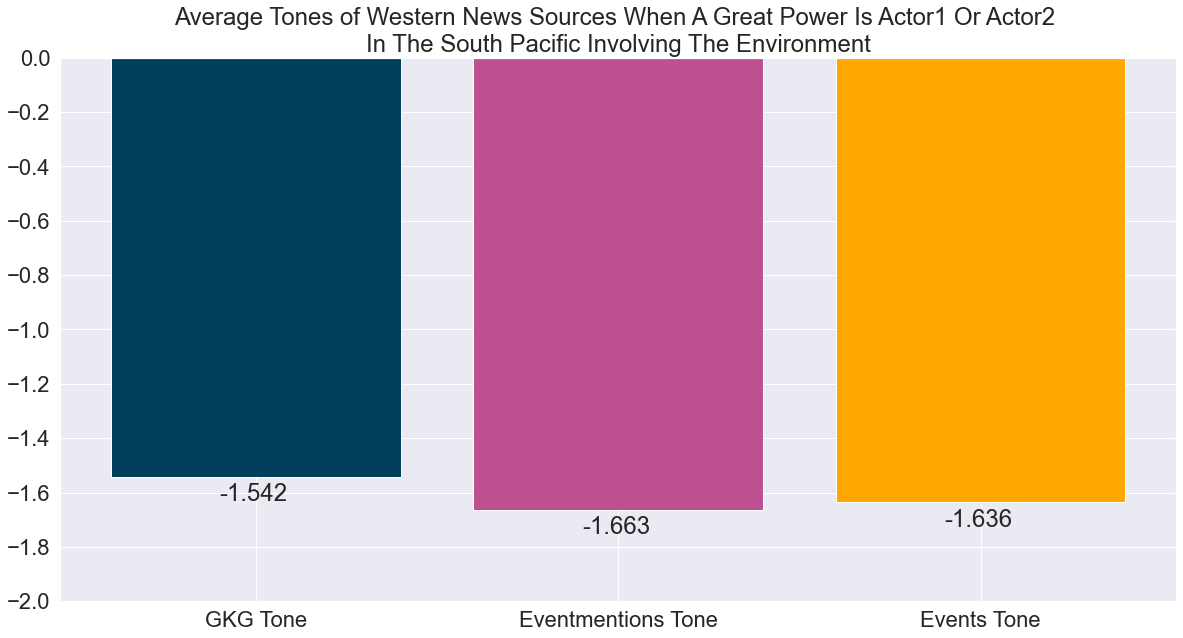

In [16]:
# Graphing the average tones
labels = ["GKG Tone","Eventmentions Tone","Events Tone"]
heights = []
    
# Computing weighted average
tot_articles = 0
avg_list = []
for i in range(0,len(result_gkg)):
    avg_list.append(num_articles[i]*result_gkg[i])
    tot_articles += num_articles[i]
heights.append(sum(avg_list)/tot_articles)

tot_articles = 0
avg_list = []
for i in range(0,len(result_em)):
    avg_list.append(num_articles[i]*result_em[i])
    tot_articles += num_articles[i]
heights.append(sum(avg_list)/tot_articles)

tot_articles = 0
avg_list = []
for i in range(0,len(result_e)):
    avg_list.append(num_articles[i]*result_e[i])
    tot_articles += num_articles[i]
heights.append(sum(avg_list)/tot_articles)

# Add tones to a list to further evaluate later
avg_western_tones.append(heights)

# Code for graph
ax = plt.bar([1,2,3], heights, color=(color1, color2, color3))
plt.xticks([1,2,3], labels)
for i, col in enumerate(ax.patches):
    plt.text(col.get_x()+0.3, col.get_height()-0.09, heights[i].round(3))
plt.yticks([0.0,-0.2,-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6,-1.8,-2.0])
plt.title('Average Tones of Western News Sources When A Great Power Is Actor1 Or Actor2 \nIn The South Pacific Involving The Environment');

With an overall average of around -1.5 to -1.6, this means that western news sources overall have a negative tone when writing about an article involving the environment in the South Pacific.

<b> Chinese Sources Tone </b>

Next, i will look at the tones of Chinese news sources. 

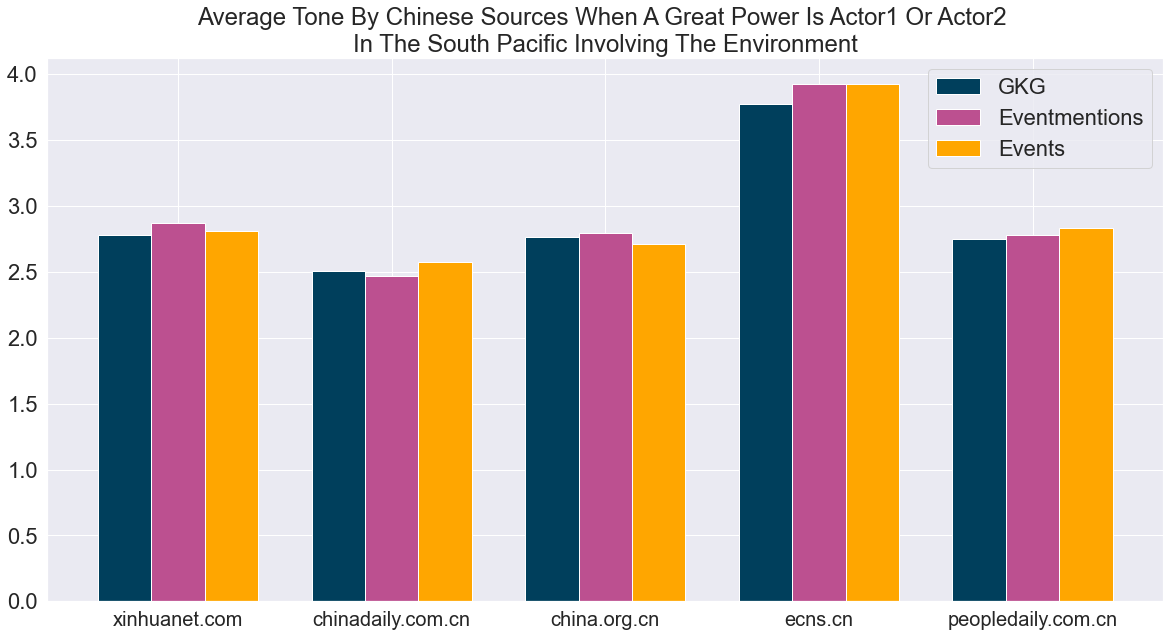

In [17]:
result_gkg = []
result_em = []
result_e = []
num_articles = []


# Loop through each one of the chinese sources and take the average of each one
for c_source in chinese_sources:
    avg_tone_gkg = df[df['SourceCommonName'] == c_source]['V2Tone_New'].mean()
    avg_tone_e = df[df['SourceCommonName'] == c_source]['AvgTone'].mean()
    avg_tone_em = df[df['SourceCommonName'] == c_source]['MentionDocTone'].mean()
    num_art = df[df['SourceCommonName'] == c_source].shape[0]
    num_articles.append(num_art)
    result_gkg.append(avg_tone_gkg)
    result_em.append(avg_tone_em)
    result_e.append(avg_tone_e)
  
# Code for graph
labels = ["GKG","Eventmentions","Events"]
fig, ax = plt.subplots()

x = np.arange(len(chinese_sources))
width = 0.25

r1 = np.arange(len(chinese_sources))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, result_gkg, color=color1, width=width, label='GKG')
ax.bar(r2, result_em, color=color2, width=width, label='Eventmentions')
ax.bar(r3, result_e, color=color3, width=width, label='Events')
ax.set_title('Average Tone By Chinese Sources When A Great Power Is Actor1 Or Actor2 \nIn The South Pacific Involving The Environment')
plt.xticks([r + width for r in range(len(chinese_sources))], chinese_sources)
ax.tick_params(axis='x', labelsize=20, rotation=0)
ax.legend();

Next, is the weighted average of all three tones.

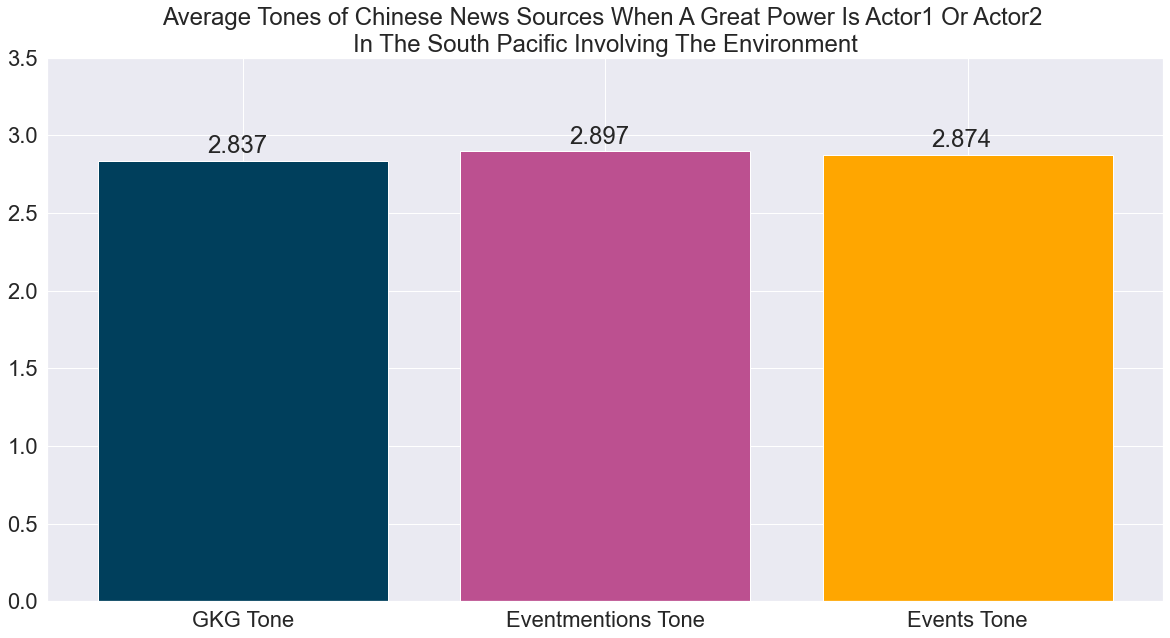

In [18]:
# Graphing the average tones
labels = ["GKG Tone","Eventmentions Tone","Events Tone"]
heights = []
    
# Computing weighted average
tot_articles = 0
avg_list = []
for i in range(0,len(result_gkg)):
    avg_list.append(num_articles[i]*result_gkg[i])
    tot_articles += num_articles[i]
heights.append(sum(avg_list)/tot_articles)

tot_articles = 0
avg_list = []
for i in range(0,len(result_em)):
    avg_list.append(num_articles[i]*result_em[i])
    tot_articles += num_articles[i]
heights.append(sum(avg_list)/tot_articles)

tot_articles = 0
avg_list = []
for i in range(0,len(result_e)):
    avg_list.append(num_articles[i]*result_e[i])
    tot_articles += num_articles[i]
heights.append(sum(avg_list)/tot_articles)

# Add tones to a list to further evaluate later
avg_chinese_tones.append(heights)

# Code for graph
ax = plt.bar([1,2,3], heights, color=(color1, color2, color3))
plt.xticks([1,2,3], labels)
for i, col in enumerate(ax.patches):
    plt.text(col.get_x()+0.3, col.get_height()+0.05, heights[i].round(3))
plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
plt.title('Average Tones of Chinese News Sources When A Great Power Is Actor1 Or Actor2 \nIn The South Pacific Involving The Environment');

With an overall average of around 2.8, this means that Chinese news sources overall have a very positive tone when writing about an article involving the environment in the South Pacific.

<b> Local Sources Tone </b>

Finally, i will look at the tones of local news sources. 

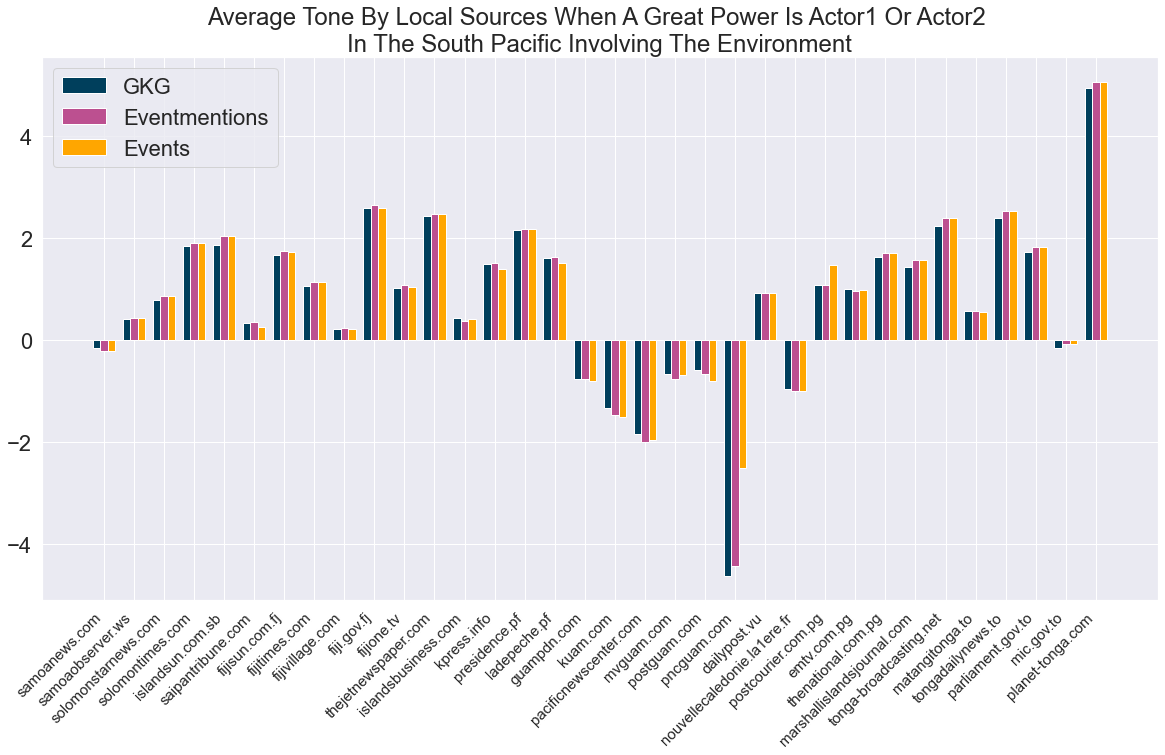

In [20]:
# Store the results to compute a weighted average
result_gkg = []
result_em = []
result_e = []
num_articles = []

# Loop through each one of the local sources and take the average of each one
for l_source in local_sources:
    avg_tone_gkg = df[df['SourceCommonName'] == l_source]['V2Tone_New'].mean()
    avg_tone_e = df[df['SourceCommonName'] == l_source]['AvgTone'].mean()
    avg_tone_em = df[df['SourceCommonName'] == l_source]['MentionDocTone'].mean()
    num_art = df[df['SourceCommonName'] == l_source].shape[0]
    num_articles.append(num_art)
    result_gkg.append(avg_tone_gkg)
    result_em.append(avg_tone_em)
    result_e.append(avg_tone_e)
    
# Code for graph
labels = ["GKG","Eventmentions","Events"]
fig, ax = plt.subplots()

x = np.arange(len(local_sources))
width = 0.25

r1 = np.arange(len(local_sources))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, result_gkg, color=color1, width=width, label='GKG')
ax.bar(r2, result_em, color=color2, width=width, label='Eventmentions')
ax.bar(r3, result_e, color=color3, width=width, label='Events')
ax.set_title('Average Tone By Local Sources When A Great Power Is Actor1 Or Actor2 \nIn The South Pacific Involving The Environment')
plt.xticks([r + width for r in range(len(local_sources))], local_sources, rotation=45, horizontalalignment='right', fontsize=15)
#ax.tick_params(axis='x', labelsize=20, rotation=85)
ax.legend();

Next, is the weighted average of all three tones.

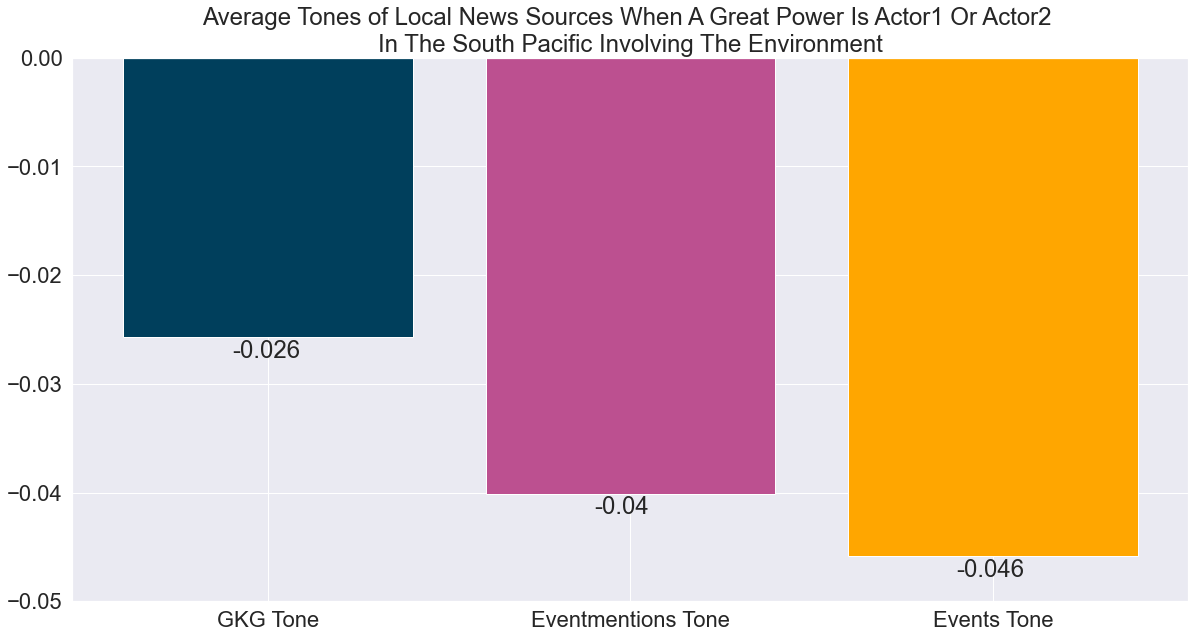

In [23]:
# Graphing the average tones
labels = ["GKG Tone","Eventmentions Tone","Events Tone"]
heights = []
    
# Computing weighted average
tot_articles = 0
avg_list = []
for i in range(0,len(result_gkg)):
    avg_list.append(num_articles[i]*result_gkg[i])
    tot_articles += num_articles[i]
heights.append(sum(avg_list)/tot_articles)

tot_articles = 0
avg_list = []
for i in range(0,len(result_em)):
    avg_list.append(num_articles[i]*result_em[i])
    tot_articles += num_articles[i]
heights.append(sum(avg_list)/tot_articles)

tot_articles = 0
avg_list = []
for i in range(0,len(result_e)):
    avg_list.append(num_articles[i]*result_e[i])
    tot_articles += num_articles[i]
heights.append(sum(avg_list)/tot_articles)

# Add tones to a list to further evaluate later
avg_local_tones.append(heights)

# Code for graph
ax = plt.bar([1,2,3], heights, color=(color1, color2, color3))
plt.xticks([1,2,3], labels)
for i, col in enumerate(ax.patches):
    plt.text(col.get_x()+0.3, col.get_height()-0.0019, heights[i].round(3))
plt.yticks([0.00,-0.01,-0.02,-0.03,-0.04,-0.05])
plt.title('Average Tones of Local News Sources When A Great Power Is Actor1 Or Actor2 \nIn The South Pacific Involving The Environment');

Local sources have an overall netural tone when writing about an article involving the environment. 

With an overall average of around 0, this means that local news sources overall have a neutral tone when writing about an article involving the environment in the South Pacific.

<h1> Methods </h1>

<b> Identifying all the locations in the South Pacific </b> 

The first step before creating a subset of data in the South Pacific was to identify all the location within the South Pacific and what there FIPS10-4 country codes are. GDELT uses the Federal Information Processing Standards (FIPS) codes to identify each events unique location. So, to only gather events in the south pacific, I need the list of all the regions and those codes. The first place I took to find all the countries and territories was Wikipedia. Wikipedia has a list of names of most of the sovereign states and dependent territories in the South Pacific. This list of names was a good list to start with. We also decided to excluded Australia and New Zealand from our initial list of nations to explore in our data because (insert reason we did that). 

Once I had my list of countries and territories that I needed to gather their location codes, I ran a query through BigQuery on the Events table to gather the columns Actor1Name, Actor1CountryCode, Actor2Name, Actor2CountyCode, Actor1Geo_FullName Actor1Geo_CountryCode, Actor2Geo_FullName, Actor2Geo_CountryCode, ActionGeo_FullName, and ActionGeo_ADM1Code into one CSV (Comma Separated Values) file. Once I had this massive CSV file of every event that happened in the Events table, I manually searched the file in excel for each corresponding location two-digit country code. I used this method instead of individually querying for each location in BigQuery because it was more time efficient to search for a location in Excel than it was to constantly be querying GDELT through BigQuery because I already had a file containing of all the locations in the Events table itself. Looking for each FIPS code within that results table also allowed me to find the exact country code that GDELT uses to specify the location instead of trusting what the internet may say their codes are. 

When using this method for finding the country code of each location in the south pacific, I was successful in identifying almost every region except for the locations of Territory of Ashmore and Cartier Islands, Galápagos Islands, midway islands, Ogasawara village, Papua Province, and West Papua. Searching for these locations either returned some results that did not seem to match the location within the south pacific or did not return a result at all. Eventually, I was able to find the names and their country codes within GDELT after querying GDELT itself. I did however initially miss-identify West Papua's ActionGeo_ADM1Code for a different part of Indonesia. I eventually found the correct ActionGeo_ADM1Code for West Papua after a series of queries made against the GDELT data set on BigQuery and using google maps to confirm the regions. 

<b> ActionGeo_ADM1Code instead of ActionGeo_CountryCode </b>

When deciding how to create a data set of the South Pacific from the GDELT data set, I decided to use ActionGeo_ADM1Code as the main predicate in the query ran through BigQuery. There are two reasons that made me decide to use ActionGeo_ADM1Code instead of ActionGeo_CountryCode or ActionGeo_FullName in my query. The first is that I found that when trying to filter a location by explicitly stating the name of the region (ActionGeo_FullName) produced a dataset with less articles compared to using the ActionGeo_ADM1Code. For example, I found that when using the filtering by ActionGeo_FullName = 'Hawaii, United States' vs using ActionGeo_ADM1Code = 'USHI', (At the time of the initial query) there was 346,532 more articles that were found using ActionGeo_ADM1Code = 'USHI'. The second reason was for consistency in which predicates I was using within the query itself. Because every ActionGeo_ADM1Code is anywhere between 2 and 4 characters and the first two characters of the ActionGeo_ADM1Code are always the same as the ActionGeo_CountryCode, I will still capture the same number of articles using ActionGeo_ADM1Code as the predicate as we would using ActionGeo_CountryCode. 

Some locations within the South Pacific however are part of regions that are not entirely considered to be in the South Pacific. For example, Indonesia has two regions that are a part of the South Pacific, but Indonesia itself is not entirely in the South Pacific. To only get those specific regions of Indonesia, I had to explicitly state the whole ActionGeo_ADM1Code for West Papua and Papua. Also, the locations of Ashmore and Cartier Islands falls underneath an ActionGeo_ADM1Code that captures more than just that region. For this reason, I had to explicitly state the regions, using the ActionGeo_FullName, of Ashmore Reef, Queensland, Australia, Coral Sea Islands, Easter Island, the Galapagos Islands, Midway Islands, Ogasawaramura Islands, and the Bonin Islands. 

<b> Joining the Events, Eventmentions, and GKG </b>

To access all the attributes about each article (Themes and Tone), I had to join the Events, Eventmentions, and GKG table together. The Events and Eventmentions table joined on the GLOBALEVENTID's and the GKG joined to the Eventmentions table through the Eventmentions MentionIdentifier is the same as the GKG DocumentIdentifier. The GLOBALEVENTID is a unique identifier that is assigned to each event that is recorded within GDELT and the MentionIdentifier and DocumentIdentifier is the exact URL (or source) where the event was published. 
    
When joining all three tables together and using only the location predicates in my query, this result data set produced a table with 4,323,833 entries. When initially deciding which columns to also include in the data set, I decided to pull every column that could be of some relevance for this research. This meant excluding many of the attributes that are in the Events, Eventmentions, and GKG table. Even with excluding most attributes, this still led to a data set that was almost 20 GB (Gigabytes) in size. With such a massive data set produced from BigQuery, it presented its own challenges on how to perform certain aggregations. 
    
Because the Pandas library from Python stores the data frame in the computers RAM (Random Access Memory), this meant I could not store more than one instance of this data set at a time. This led to issues when I used the SQLite library using Python to perform queries on the data set. Because SQLite also stores its data base in memory (instead of the disk drive like a traditional SQL engine), I had to load the data set directly into SQLite from Pandas and delete the instance of that data set immediately after it was done to perform queries. To conserve memory within my computer, I eventually made mini data sets of only the attributes used in this research so I could hold both an instance of the data set in Pandas and in SQLite. Doing this allowed me to do data aggregation with SQL and then further analysis using Python without having to constantly drop one instance to use the other.

<b> SQL as the predicate to filter for themes </b>

In the GKG table, the two attributes of interest for this research are the Themes and the Tones. The Themes are how we were able to filter by only looking at certain events that involved the environment. The environmental themes of interest are filtered by using '%ENV_%' within the where predicate in my queries. There are 21 different environmental themes that GDELT has created: ENV_CLIMATECHANGE, ENV_OIL, ENV_FISHERY, ENV_MINING, ENV_COAL, ENV_GREEN,ENV_SOLAR, ENV_METALS, ENV_POACHING, ENV_NATURALGAS, ENV_DEFORESTATION, ENV_OVERFISH, ENV_FORESTRY, ENV_NUCLEARPOWER, ENV_WATERWAYS, ENV_SPECIESENDANGERED, ENV_HYDRO, ENV_BIOFUEL, ENV_GEOTHERMAL, ENV_WINDPOWER, ENV_CARBONCAPTURE and ENV_SPECIESEXTINCT. GDELT also has the World Bank themes included in the themes column. The World Bank themes offer even greater details in their themes than what GDELT has provided with its own themes. But for this research, I will only be filtering by the themes that begin with 'ENV_' because the World Bank themes do not follow such a uniform structure. Therefore, making it exceedingly difficult to only filter by a certain kind of World Bank theme. 
    
<b> V2Themes vs Themes </b>

Within the GKG table, there are two themes columns. One is labeled Themes and the other V2Themes. After doing a detailed analysis of both columns, I concluded that both columns produced nearly identical results and choosing one over the other was not as important for this research. The major differences between the Themes and V2Themes is the V2Themes states the location within the article where the theme was identified. V2Themes also allows for the same theme to appear more than once in the column if it appears more than once in the event. The regular Themes is only a list of each unique theme as it appears in the event. For this research, I decided to use V2Themes instead of Themes when filtering by articles involving the environment. I could have however used the regular Themes and gotten the same results for this research. 
    
<b> Tones </b>
    
Even though the Events and Eventmentions tables also has a tone attribute, I wanted to present all three of them in this report. There is a slight difference on how each of the tones are calculated in each table. The tone in the Events table only represents the average tone of all the article that reported the event within the first 15 minutes it was first seen, the Eventmentions tone is the tone of each individual article, and the GKG tone is calculated from taking the average of the positive and negative score of the whole document. The tones, and positive and negative scores are automatically generated by GDELT using sentiment analysis. The exact algorithms are not mentioned but GDELT promises that it is an advance Natural Language Processing (NLP) algorithms that generates these scores.
    
<b> Great Powers </b>

There is two ways that we can specify when looking for articles only involving the great powers of interest. The first way is by looking for the Actor1/2CountryCodes and the other is the Actor1/2Geo_CountryCode. While the ActorGeo_CountryCode method uses the FIPS country codes to specify who the actors are, the attribute Actor1CountryCode (and Actor2CountryCode) uses a 3-character CAMEO code for the country affiliations. There are resources online to find the Actor1/2CountryCode of each of the countries we are looking for. Instead of turning to the internet, i searched the data sets i had already created using Pandas functions. I was able to get the exact ActorCountryCodes this way and knew that these codes would give me what i was looking for. 
    
I decided to use the ActorCountryCode instead of ActorGeo_CountryCode as my means for creating a data set only containing the great powers because when comparing the results of using both, using Actor1/2Geo_CountryCode for specifying an actor produced a data set with less than half of the articles compared to using the Actor1/2CountryCode. The Events table in GDELT only specifies two actors and a location. So if multiple actors are present, GDELT will either leave the field blank or will choose which actors take precedence in the article and assign those actors to those attributes. But, the Actor1/2CountryCodes do not always match. For instance, "if the text refers to 'French Assistant Minister Smith was in Moscow', the CountryCode field will list France in the CountryCode field, while the geographic fields may list Moscow as the location". While this leads to potentially missing some articles invloving certain actors, if we were to look for actors by either there location (ActorGeo_CountryCode) or there precedence in the artcile (ActorCountryCode), we may be including articles where we have an actors location who maybe was not an actor in the article itself. On the other hand, when specifying having the ActorCountryCode and ActorGeo_CountryCode matching, only produced a data set that only contained a fraction of the amount of events (10's of thousands compared to hundreds of thousands). 

<b> Media Sources </b>

When finding the local media sources of the South Pacific, i created a function to output every unique media source that has involves a great power as Actor1 or Actor2. From there, my research mentor (Dr. Elizabeth Gooch) went through the list of sources for each individual location and cross checked each source to see if it was a local source. The Western news sources were selected because they give a range of liberal, conservative, and neutral media outlets. The Chinese news sources were select because each one of those news sources are either state-owned, state-ran, or authorized by the Chinese government. 

<b> Calculating the tones for all the media sources </b>

Once i had the geographical locations, the CAMEO codes for each great power, and the proper filtering methods for creating subsets of data, i then created multiple Python functions to compute the average tone for each news source in the South Pacific. 

Sources: <br>
https://en.wikipedia.org/wiki/Oceania <br>
http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.1.pdf <br>
http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf <br>

<h1> Results </h1>

Below is a visualization of each of each of the media sources and there average tones in the South Pacific, involving a great power, and involving the environment. 

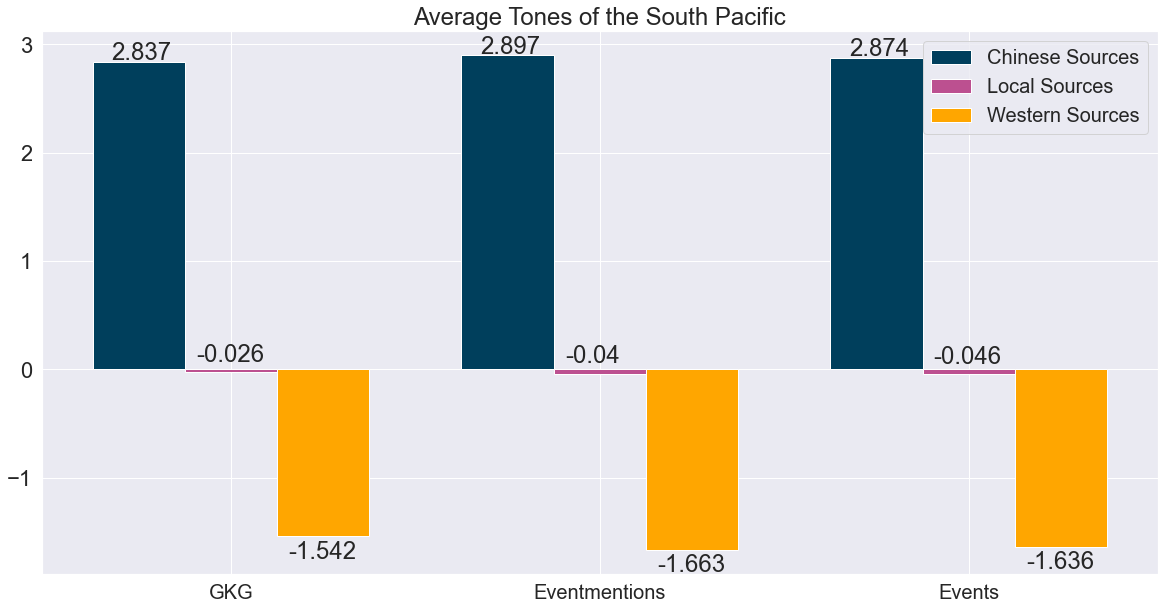

In [284]:
temp1 = np.array(avg_chinese_tones).flatten()
temp2 = np.array(avg_local_tones).flatten()
temp3 = np.array(avg_western_tones).flatten()
labels = np.concatenate((temp1, temp2, temp3)).tolist()

fig, ax = plt.subplots()

x = np.arange(3)
width = 0.25

r1 = np.arange(3)
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, np.array(avg_chinese_tones).flatten().tolist(), color=color1, width=width, label='Chinese Sources')
ax.bar(r2, np.array(avg_local_tones).flatten().tolist(), color=color2, width=width, label='Local Sources')
ax.bar(r3, np.array(avg_western_tones).flatten().tolist(), color=color3, width=width, label='Western Sources')

ax.set_title('Average Tones of the South Pacific Involving The Environment By Chinese, Local, And Western Sources')
plt.xticks([r + width for r in range(3)], ['GKG','Eventmentions','Events'], fontsize=20)

# Add the labels  
for i, col in enumerate(ax.patches):
    if i < 3:
        plt.text(x = col.get_x()+0.05, y = col.get_height()+0.02, s=round(labels[i],3))
    elif i < 6:
        plt.text(x = col.get_x()+0.03, y = col.get_height()+0.1, s=round(labels[i],3))
    else:
        plt.text(x = col.get_x()+0.03, y = col.get_height()-0.2, s=round(labels[i],3))
        
ax.legend(fontsize='small');

We can see that Chinese news sources have an overall very positive tone, local sources have a neutral tone, and Western sources has a negative tone. 

<h1> Conclusion </h1>

In this report, i showed that the number of articles within GDELT that have an event located in the South Pacific only accounts for 0.08% of the articles within GDELT itself. I then showed that of the 4.31 million articles, 20.34% of those involve an environmental theme. Afterwards, i showed that when a great power was an actor in an event in the South Pacific, 31.58% of those events had an environmental theme. Next, i showed the breakdown of articles involving an environmental theme in the South Pacific by great power. I then showed the portions of articles written by local news sources in the South Pacific and how many articles that involved an environmental theme in the South Pacific had a great power as one of the actors. Next, i showed each of the Chinese, local, and western news sources average tones when involving the environment in the South Pacific. Finally, i showed that Chinese sources have an overall very positive tone in the South Pacific when the event itself involves the environment, local news sources have a neutral tone, and western sources have a negative tone.  